In [358]:
import torch
import torch.nn as nn
import pandas as pd
from normalizer import normalize
from transformers.modeling_outputs import TokenClassifierOutput, SequenceClassifierOutput
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig

In [359]:
# Load Data
train = pd.read_csv('data/train.csv')
validation = pd.read_csv('data/dev.csv')

In [360]:
validation

,text,label
0,পাডা পুতার মাঝখানে পরে সাধারণ ২ মানুষের জিবন শ...,0
1,করোনার চাপে অনেক কিছু বন্ধ ও অনেক বিধি নিষেধ ক...,0
2,সঠিক তদন্ত করতে হবে। বিচারের আওতায় আনতে হবে য...,0
3,যে লোকটা মারা গেছে তার কি হবে তার দায়ভার কে ন...,0
4,নিউ মার্কেট এবং গুলিস্থান মার্কেটের ব্যবসায়ীর...,1
...,...,...
1325,নাটক টা সুন্দর ভাবে সাজিয়েছে আরো কত কিছু দেখত...,1
1326,নোংরা দেশ আর নোংরা জাতি হচ্ছে ভারত এঁরা কি বুঝ...,1
1327,জে ছেলে মারা গেছে ওর কি হবে,0
1328,এরাই নৈরাজ্য সৃষ্টি করছে,1


In [361]:
#train = train.rename(columns={"label": "label_name"}) # change headings
#validation = validation.rename(columns={"label": "label_name"}) # change headings

In [362]:
# Map labels

id2label = {
    0 : 'Non-Violence',
    1 : 'Passive Violence',
    2 : 'Direct Violence'
}

label2id = {
    'Non-Violence': 0,
    'Passive Violence': 1,
    'Direct Violence': 2
}

#train['label'] = train['label_name'].map(label2id)
#validation['label'] = validation['label_name'].map(label2id)

In [363]:
#train = train.drop(columns=['id', 'label_name'], axis=1)
#validation = validation.drop(['id', 'label_name'], axis=1)

In [364]:
validation

,text,label
0,পাডা পুতার মাঝখানে পরে সাধারণ ২ মানুষের জিবন শ...,0
1,করোনার চাপে অনেক কিছু বন্ধ ও অনেক বিধি নিষেধ ক...,0
2,সঠিক তদন্ত করতে হবে। বিচারের আওতায় আনতে হবে য...,0
3,যে লোকটা মারা গেছে তার কি হবে তার দায়ভার কে ন...,0
4,নিউ মার্কেট এবং গুলিস্থান মার্কেটের ব্যবসায়ীর...,1
...,...,...
1325,নাটক টা সুন্দর ভাবে সাজিয়েছে আরো কত কিছু দেখত...,1
1326,নোংরা দেশ আর নোংরা জাতি হচ্ছে ভারত এঁরা কি বুঝ...,1
1327,জে ছেলে মারা গেছে ওর কি হবে,0
1328,এরাই নৈরাজ্য সৃষ্টি করছে,1


In [365]:
train['text'] = pd.DataFrame(train['text'].map(lambda x: normalize(x)))
validation['text'] = pd.DataFrame(validation['text'].map(lambda x: normalize(x)))

In [366]:
from datasets import load_dataset

# Split Data
random_seed = 42
train_df = train.sample(frac=1, random_state=random_seed)
#valid_df = train.drop(train_df.index) # select partial training data
valid_df = validation

#assert len(train) == len(train_df) + len(valid_df), "Dataset sizes don't add up" # check for proper split

# Create New Data Files
valid_df.to_csv('./data_gen/validation_data.csv', index=False)
train_df.to_csv('./data_gen/train_data.csv', index=False)
#validation.to_csv('./data_gen/test_data.csv', index=False)

# Load Data (train + val)
training_data = load_dataset("csv", data_files={'train': ['./data_gen/train_data.csv'],'validation': ['./data_gen/validation_data.csv']})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/rohan/.cache/huggingface/datasets/csv/default-a7b284f72a1a62a9/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [367]:
from sklearn.metrics import accuracy_score, f1_score 

# Helper Functions
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_weighted = f1_score(labels, preds, average="weighted")
    f1_macro = f1_score(labels, preds, average="macro") 
    f1_micro = f1_score(labels, preds, average="micro") 
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1_weighted": f1_weighted, "f1_macro": f1_macro, "f1_micro": f1_micro}


In [368]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch

num_labels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ckpt = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=256)

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))
training_data_encoded = training_data.map(tokenize, batched=True, batch_size=64)

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Map:   0%|          | 0/1330 [00:00<?, ? examples/s]

## Freeze

In [369]:
# n = 7  # Change this to the number of layers you want to freeze
# for i in range(n):
#     for param in model.electra.encoder.layer[i].parameters():
#         param.requires_grad = False

In [370]:
device

device(type='cuda')

## Setup Experiment

In [371]:
from transformers import Trainer, TrainingArguments 
batch_size = 64
logging_steps = len(training_data_encoded["train"]) // batch_size 
model_name = f"{model_ckpt}-violence-inciting-text"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10, 
                                  #num_training_steps=100, 
                                  learning_rate=2e-5,
                                  #warmup_steps=10000,
                                  per_device_train_batch_size=batch_size, 
                                  per_device_eval_batch_size=batch_size, 
                                  eval_steps=100,
                                  logging_steps = 100,
                                  weight_decay=0.01,
                                  evaluation_strategy="steps", 
                                  save_strategy="steps",
                                  disable_tqdm=False,
                                  #logging_steps=logging_steps,
                                  save_steps = 100, 
                                  save_total_limit = 2,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1_macro",
                                  greater_is_better=True,
                                  optim='adamw_torch',
                                  lr_scheduler_type= "linear", #cosine_with_restarts
                                  log_level="error")

In [372]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [373]:
%%capture
#!sudo apt-get install git-lfs
from transformers import Trainer
# select Trainer
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=training_data_encoded["train"], 
                  eval_dataset=training_data_encoded["validation"],
                  data_collator=data_collator,
                  tokenizer=tokenizer)

In [374]:
tokenizer('asd')

{'input_ids': [2, 4542, 465, 3], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [375]:
trainer.train() # Label Encode.... Use Dataset name as Feature... Find other feature... create word map

Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 23.70 GiB total capacity; 11.65 GiB already allocated; 21.81 MiB free; 12.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [357]:
preds_output = trainer.predict(training_data_encoded["validation"])
preds_output.metrics

{'test_loss': 1.137454628944397,
 'test_accuracy': 0.8293233082706767,
 'test_f1_weighted': 0.8292269151387627,
 'test_f1_macro': 0.815951709356554,
 'test_f1_micro': 0.8293233082706768,
 'test_runtime': 1.8362,
 'test_samples_per_second': 724.335,
 'test_steps_per_second': 90.95}

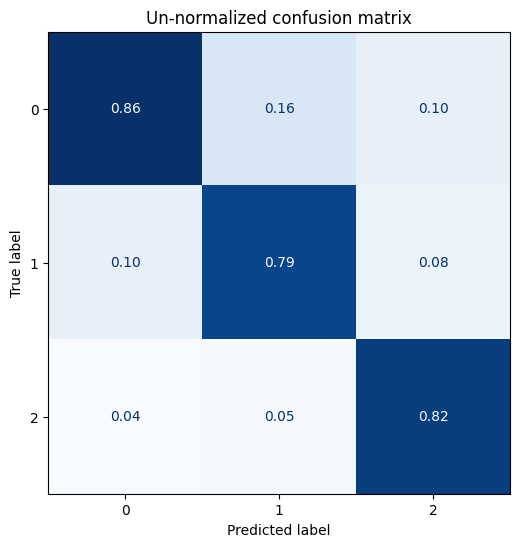

In [338]:
import numpy as np
import matplotlib.pyplot as plt

y_preds = np.argmax(preds_output.predictions, axis=1)
#labels = training_data_encoded["train"].features["label"].names
labels = [0,1,2]
y_valid = training_data_encoded["validation"]["label"]

plot_confusion_matrix(y_preds, y_valid, labels)


# Inspect Loss on Train/Validation Datapoints

In [290]:
from torch.nn.functional import cross_entropy 
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model 
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}

    with torch.no_grad(): 
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        #class_weight = torch.FloatTensor([1, 1.25]).to(device)

        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns 
    return {"loss": loss.cpu().numpy(),
    "predicted_label": pred_label.cpu().numpy()}


In [291]:
# Convert our dataset back to PyTorch tensors
training_data_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
#test_data_encoded["test"] = test_data_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=16)
training_data_encoded["train"] = training_data_encoded["train"].map(forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

In [292]:
training_data_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"] 
df_train_loss = training_data_encoded["train"][:][cols]
#df_test["label"] = df_test["label"].apply(label_int2str) 
#df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))
df_train_loss.sort_values("loss", ascending=False).head(500)


,text,label,predicted_label,loss
2080,"খোদার কসম করে বলছি আমি নিজেও আওয়ামিলীগ করি, ক...",1,0,6.546422
425,নাহিদের বাবা ঠিকই জানেন এদেশে বিচার হবে না তদন...,0,1,6.381577
689,বড় আফসোস ভারতের বোনেরা হিজাব রক্ষার জন্য লড়া...,1,0,6.306884
969,সকল মুসলিম ভাই ভাই তাই কোন দোষ নাই,1,0,6.151897
1837,"এমন সুন্দর কোমল, মোলায়েম সাক্ষাৎকার কখনো দেখে...",1,0,6.035587
...,...,...,...,...
2558,হিন্দু জংগি সংঘটন মোদি সরকার হটাও। হিন্দু সন্ত...,1,1,0.014612
1088,ইকবালের বেলায় পরিবার ও দায় নেবে না আর ওর জাত...,0,0,0.013778
680,ধর্মের ব্যাপারে নিরপহ্ম মানেই জাহান্নামি! ভালো...,1,1,0.013637
379,ষড়যন্ত্রকারীরা কত শক্তিশালী! অঘটন ঘটানোর জন্য...,0,0,0.013260


In [227]:
df_train_loss.sort_values("loss", ascending=False).head(200).to_csv("ErrorAnalysis.csv")

In [228]:
model

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L